## Importação dos pacotes

In [1]:
# importar pacotes necessários
import numpy as np
import pandas as pd

In [2]:
# definir parâmetros extras
pd.set_option('precision', 4)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings("ignore")

## Carga dos dados

In [75]:
#prefixo_arquivos = ''
prefixo_arquivos = 'https://github.com/hjort/ai-labs/raw/master/kaggle/serpro-titanic/'

In [76]:
# carregar arquivo de dados de treino
train_data = pd.read_csv(prefixo_arquivos + 'titanic-train.csv', index_col='person')

In [77]:
# carregar arquivo de dados de teste
test_data = pd.read_csv(prefixo_arquivos + 'titanic-test.csv', index_col='person')

In [78]:
# unir ambos os dados de treino e teste
data = pd.concat([train_data, test_data])

# mostrar alguns exemplos de registros
data.head()

,age,cabin,embarked,fare,home_destination,name,parch,pclass,sex,sibsp,survived,ticket
person,,,,,,,,,,,,
416,16.0,NaN,S,26.000,"Liverpool / Montreal, PQ","Gaskell, Mr. Alfred",0,2,male,0,no,239865
194,30.0,C106,S,26.000,"Brockton, MA","Maguire, Mr. John Edward",0,1,male,0,no,110469
600,42.0,NaN,S,7.550,NaN,"Abbing, Mr. Anthony",0,3,male,0,no,C.A. 5547
1112,3.0,NaN,S,13.775,NaN,"Peacock, Miss. Treasteall",1,3,female,1,no,SOTON/O.Q. 3101315
878,25.0,NaN,S,7.925,NaN,"Ilmakangas, Miss. Pieta Sofia",0,3,female,1,no,STON/O2. 3101271


## Transformações nos dados

In [79]:
# transformar colunas textuais em categóricas
data['survived'] = data['survived'].map({'yes': 1, 'no': 0})

In [80]:
# extrair títulos das pessoas a partir do nome
data['title'] = data['name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# exibir relação entre título e sexo
pd.crosstab(data['title'], data['sex']).T

title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [81]:
# agregar títulos incomuns
replacements = {
    'Miss': ['Mlle', 'Ms'],
    'Mrs': ['Mme'],
    'Rare': ['Lady', 'Countess', 'Capt', 'Col', 'Don', \
             'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
}
for k, v in replacements.items():
    data['title'] = data['title'].replace(v, k)
    
# exibir relação entre título e sexo
pd.crosstab(data['title'], data['sex']).T

title,Master,Miss,Mr,Mrs,Rare
sex,,,,,
female,0,264,0,198,4
male,61,0,757,0,25


In [82]:
# categorizar os valores dos títulos
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
data['title'] = data['title'].map(title_mapping)
data['title'] = data['title'].fillna(0)

In [83]:
# categorizar os valores dos sexos
data['sex'] = data['sex'].map({'female': 1, 'male': 0}).astype(int)

In [84]:
# preencher e categorizar os valores dos portos de embarque
data['embarked'].fillna(data.embarked.mode()[0], inplace=True)
data['embarked'] = data['embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

In [85]:
# preencher os valores da passagem
data['fare'].fillna(data.fare.mean(), inplace=True)

In [86]:
# criar coluna com tamanho da família
data['fsize'] = data['parch'] + data['sibsp'] + 1

In [87]:
# criar coluna indicando se estava sozinho
data['alone'] = 0
data.loc[data.fsize == 1, 'alone'] = 1

In [88]:
# criar coluna contendo o deque
data['deck'] = data['cabin'].str[:1]
data['deck'] = data['deck'].fillna('N').astype('category')
data['deck'] = data['deck'].cat.codes

In [89]:
# criar coluna contendo o número do quarto
data['room'] = data['cabin'].str.extract("([0-9]+)", expand=False)
data['room'] = data['room'].fillna(0).astype(int)

In [90]:
data.head()

,age,cabin,embarked,fare,home_destination,name,parch,pclass,sex,sibsp,survived,ticket,title,fsize,alone,deck,room
person,,,,,,,,,,,,,,,,,
416,16.0,NaN,0,26.000,"Liverpool / Montreal, PQ","Gaskell, Mr. Alfred",0,2,0,0,0.0,239865,1,1,1,7,0
194,30.0,C106,0,26.000,"Brockton, MA","Maguire, Mr. John Edward",0,1,0,0,0.0,110469,1,1,1,2,106
600,42.0,NaN,0,7.550,NaN,"Abbing, Mr. Anthony",0,3,0,0,0.0,C.A. 5547,1,1,1,7,0
1112,3.0,NaN,0,13.775,NaN,"Peacock, Miss. Treasteall",1,3,1,1,0.0,SOTON/O.Q. 3101315,2,3,0,7,0
878,25.0,NaN,0,7.925,NaN,"Ilmakangas, Miss. Pieta Sofia",0,3,1,1,0.0,STON/O2. 3101271,2,2,0,7,0


### Inferir idades faltantes dos passageiros

In [91]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def evaluate_regression_model(model, X, y):
    kfold = KFold(n_splits=10, random_state=42)
    results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error', verbose=1)
    score = (-1) * results.mean()
    stddev = results.std()
    print(model, '\nScore: %.2f (+/- %.2f)' % (score, stddev))
    return score, stddev

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

age_models = [
#    ('LR', LinearRegression(n_jobs=-1, fit_intercept=True, normalize=True)),
    ('GBR', GradientBoostingRegressor(random_state=42)),
    ('RFR', RandomForestRegressor(random_state=42)),
    ('XGB', XGBRegressor(random_state=42, objective='reg:squarederror')),
#    ('MLP', MLPRegressor(random_state=42, max_iter=500, activation='tanh',
#                         hidden_layer_sizes=(10,5,5), solver='lbfgs')),
#    ('GPR', GaussianProcessRegressor(random_state=42, alpha=0.01, normalize_y=True))
]

In [93]:
# selecionar dados para o treino
data_age = data[['pclass', 'sibsp', 'parch', 'fare', 'sex', 'embarked', 'title', 'age', 'alone']].dropna()

X_age = data_age.drop(['age'], axis=1)
y_age = data_age['age']

data_age.head()

,pclass,sibsp,parch,fare,sex,embarked,title,age,alone
person,,,,,,,,,
416,2,0,0,26.000,0,0,1,16.0,1
194,1,0,0,26.000,0,0,1,30.0,1
600,3,0,0,7.550,0,0,1,42.0,1
1112,3,1,1,13.775,1,0,2,3.0,0
878,3,1,0,7.925,1,0,2,25.0,0


In [94]:
names = []
scores = []
lowest = 999
best_model = None

for name, model in age_models:
    
    score, stddev = evaluate_regression_model(model, X_age, y_age)
    names.append(name)
    scores.append(score)
    
    if score < lowest:
        best_model = model
        lowest = score

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 113.13 (+/- 12.33)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False) 
Score: 133.25 (+/- 12.91)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1) 
Score: 111.82 (+/-

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished


In [95]:
results = pd.DataFrame({'Age Model': names, 'Score': scores})
results.sort_values(by='Score', ascending=True)

,Age Model,Score
2,XGB,111.8220
0,GBR,113.1299
1,RFR,133.2506


In [96]:
age_model = best_model
age_model.fit(X_age, y_age)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [97]:
# preencher dados faltantes de idade a partir de uma regressão
data['age_pred'] = age_model.predict(
    data[['pclass', 'sibsp', 'parch', 'fare', 'sex', 'embarked', 'title', 'alone']])
data.loc[data.age.isnull(), 'age'] = data['age_pred']
data.drop('age_pred', axis=1, inplace=True)
data.head()

,age,cabin,embarked,fare,home_destination,name,parch,pclass,sex,sibsp,survived,ticket,title,fsize,alone,deck,room
person,,,,,,,,,,,,,,,,,
416,16.0,NaN,0,26.000,"Liverpool / Montreal, PQ","Gaskell, Mr. Alfred",0,2,0,0,0.0,239865,1,1,1,7,0
194,30.0,C106,0,26.000,"Brockton, MA","Maguire, Mr. John Edward",0,1,0,0,0.0,110469,1,1,1,2,106
600,42.0,NaN,0,7.550,NaN,"Abbing, Mr. Anthony",0,3,0,0,0.0,C.A. 5547,1,1,1,7,0
1112,3.0,NaN,0,13.775,NaN,"Peacock, Miss. Treasteall",1,3,1,1,0.0,SOTON/O.Q. 3101315,2,3,0,7,0
878,25.0,NaN,0,7.925,NaN,"Ilmakangas, Miss. Pieta Sofia",0,3,1,1,0.0,STON/O2. 3101271,2,2,0,7,0


In [98]:
# existem colunas com dados nulos?
data[data.columns[data.isnull().any()]].isnull().sum()

cabin               1014
home_destination     564
survived             437
dtype: int64

In [99]:
data.head()

,age,cabin,embarked,fare,home_destination,name,parch,pclass,sex,sibsp,survived,ticket,title,fsize,alone,deck,room
person,,,,,,,,,,,,,,,,,
416,16.0,NaN,0,26.000,"Liverpool / Montreal, PQ","Gaskell, Mr. Alfred",0,2,0,0,0.0,239865,1,1,1,7,0
194,30.0,C106,0,26.000,"Brockton, MA","Maguire, Mr. John Edward",0,1,0,0,0.0,110469,1,1,1,2,106
600,42.0,NaN,0,7.550,NaN,"Abbing, Mr. Anthony",0,3,0,0,0.0,C.A. 5547,1,1,1,7,0
1112,3.0,NaN,0,13.775,NaN,"Peacock, Miss. Treasteall",1,3,1,1,0.0,SOTON/O.Q. 3101315,2,3,0,7,0
878,25.0,NaN,0,7.925,NaN,"Ilmakangas, Miss. Pieta Sofia",0,3,1,1,0.0,STON/O2. 3101271,2,2,0,7,0


In [100]:
data.head()

,age,cabin,embarked,fare,home_destination,name,parch,pclass,sex,sibsp,survived,ticket,title,fsize,alone,deck,room
person,,,,,,,,,,,,,,,,,
416,16.0,NaN,0,26.000,"Liverpool / Montreal, PQ","Gaskell, Mr. Alfred",0,2,0,0,0.0,239865,1,1,1,7,0
194,30.0,C106,0,26.000,"Brockton, MA","Maguire, Mr. John Edward",0,1,0,0,0.0,110469,1,1,1,2,106
600,42.0,NaN,0,7.550,NaN,"Abbing, Mr. Anthony",0,3,0,0,0.0,C.A. 5547,1,1,1,7,0
1112,3.0,NaN,0,13.775,NaN,"Peacock, Miss. Treasteall",1,3,1,1,0.0,SOTON/O.Q. 3101315,2,3,0,7,0
878,25.0,NaN,0,7.925,NaN,"Ilmakangas, Miss. Pieta Sofia",0,3,1,1,0.0,STON/O2. 3101271,2,2,0,7,0


## Modelagem preditiva

In [101]:
# importar os pacotes necessários para os algoritmos de classificação
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [102]:
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# avalia o desempenho do modelo, retornando o valor da precisão
def evaluate_classification_model(model, X, y):
    start = datetime.now()
    kfold = KFold(n_splits=10, random_state=42)
    results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy', verbose=1)
    end = datetime.now()
    elapsed = int((end - start).total_seconds() * 1000)
    score = 100.0 * results.mean()
    stddev = 100.0 * results.std()
    print(model, '\nScore: %.2f (+/- %.2f) [%5s ms]' % (score, stddev, elapsed))
    return score, stddev, elapsed

In [103]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# faz o ajuste fino do modelo, calculando os melhores hiperparâmetros
def fine_tune_model(model, params, X, y):
    print('\nFine Tuning Model:')
    print(model, "\nparams:", params)
    kfold = KFold(n_splits=10, random_state=42)
    grid = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=kfold, verbose=1)
    grid.fit(X, y)
    print('\nGrid Best Score: %.2f' % (grid.best_score_ * 100.0))
    print('Best Params:', grid.best_params_)
    return grid

In [104]:
# definir dados de treino
train_data = data[data.survived.isnull() == False]

# selecionar atributos para o modelo
cols = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'title', 'fsize', 'alone', 'deck']
#cols = ['pclass', 'sex', 'age', 'fare', 'title', 'fsize', 'deck']
#cols = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'title', 'fsize', 'alone', 'deck', 'room']

X_train = train_data[cols]
y_train = train_data['survived']

print('Forma dos dados de treino:', X_train.shape, y_train.shape)

Forma dos dados de treino: (872, 11) (872,)


In [105]:
# definir dados de teste
test_data = data[data.survived.isnull()]

X_test = test_data[cols]

print('Forma dos dados de teste:', X_test.shape)

Forma dos dados de teste: (437, 11)


In [106]:
names = []
models = []
scores = []
stddevs = []
times = []

def add_model_info(name, model, score, stddev, elapsed):
    names.append(name)
    models.append((name, model))
    scores.append(score)
    stddevs.append(stddev)
    times.append(elapsed)

## Avaliação e ajuste fino de cada modelo preditivo

-  https://scikit-learn.org/stable/modules/classes.html

### Generalized Linear Models

In [107]:
model = LogisticRegression(random_state=42, solver='lbfgs', multi_class='auto', max_iter=500, C=0.1)

params = dict(
    solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    C=np.logspace(-3, 3, 7)
)
#fine_tune_model(model, params, X_train, y_train)

score, stddev, elapsed = evaluate_classification_model(model, X_train, y_train)
add_model_info('LR', model, score, stddev, elapsed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 
Score: 79.94 (+/- 5.12) [ 6181 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.2s finished


### Decision Trees

In [108]:
model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=3)

#criterion=’mse’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, 
#min_impurity_decrease=0.0, min_impurity_split=None, presort=False

params = dict(
    criterion=['gini','entropy'],
    max_depth=[4, 6, 8, 10, 12, 14],
    min_samples_split=[0.25, 0.5, 0.75, 1.0]
)
#fine_tune_model(model, params, X_train, y_train)

score, stddev, elapsed = evaluate_classification_model(model, X_train, y_train)
add_model_info('DT', model, score, stddev, elapsed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best') 
Score: 79.48 (+/- 4.03) [  325 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


### Naïve Bayes

In [109]:
model = GaussianNB(priors=None, var_smoothing=1e-8)

#priors=None, var_smoothing=1e-09

params = dict(
    priors=[None],
    var_smoothing=[1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
)
#fine_tune_model(model, params, X_train, y_train)

score, stddev, elapsed = evaluate_classification_model(model, X_train, y_train)
add_model_info('NB', model, score, stddev, elapsed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianNB(priors=None, var_smoothing=1e-08) 
Score: 76.04 (+/- 6.24) [  343 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


### Nearest Neighbors

In [110]:
model = KNeighborsClassifier(n_neighbors=9)

#n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’,
#metric_params=None, n_jobs=None

params = dict(
    n_neighbors=[1, 3, 5, 7, 9, 11, 13],
    weights=['uniform', 'distance']
)
#fine_tune_model(model, params, X_train, y_train)

score, stddev, elapsed = evaluate_classification_model(model, X_train, y_train)
add_model_info('KNN', model, score, stddev, elapsed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform') 
Score: 70.42 (+/- 3.44) [  467 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


### Support Vector Machines

In [111]:
model = SVC(random_state=42, C=10, gamma=0.1, kernel='rbf')

#kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, tol=0.001, C=1.0, 
#epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1

params = dict(
    C=[0.001, 0.01, 0.1, 1, 10, 100],
    gamma=[0.001, 0.01, 0.1, 1, 10, 100],
    kernel=['linear', 'rbf']
)
#fine_tune_model(model, params, X_train, y_train)

score, stddev, elapsed = evaluate_classification_model(model, X_train, y_train)
add_model_info('SVM', model, score, stddev, elapsed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False) 
Score: 69.73 (+/- 4.31) [ 4712 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished


### Neural network models

In [112]:
model = MLPClassifier(random_state=42, solver='lbfgs', alpha=0.1, hidden_layer_sizes=(15,10,5))

#hidden_layer_sizes=(100, ), activation=’relu’, solver=’adam’, alpha=0.0001, batch_size=’auto’, 
#learning_rate=’constant’, learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
#random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
#early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10

params = dict(
    alpha=[1,0.1,0.01,0.001,0.0001,0],
    hidden_layer_sizes=[(100,), (50,), (50,2), (5,5,2), (10,5,2)],
    activation=['identity', 'logistic', 'tanh', 'relu'],
    solver=['lbfgs', 'sgd', 'adam']
)
#fine_tune_model(model, params, X_train, y_train)

score, stddev, elapsed = evaluate_classification_model(model, X_train, y_train)
add_model_info('MLP', model, score, stddev, elapsed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(15, 10, 5), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False) 
Score: 75.46 (+/- 4.93) [14153 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.1s finished


### Ensemble Methods

In [113]:
model = RandomForestClassifier(random_state=42, max_features='auto', n_estimators=100)

#n_estimators=’warn’, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
#verbose=0, warm_start=False

params = dict(
    n_estimators=[10, 50, 100, 500],
    max_features=['auto', 'sqrt', 'log2'],
    max_depth=[None, 3, 5, 7, 9, 11, 13]
)
#fine_tune_model(model, params, X_train, y_train)

score, stddev, elapsed = evaluate_classification_model(model, X_train, y_train)
add_model_info('RF', model, score, stddev, elapsed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False) 
Score: 78.56 (+/- 2.89) [10964 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.0s finished


In [114]:
model = GradientBoostingClassifier(random_state=42, max_depth=3)

#loss=’ls’, learning_rate=0.1, n_estimators=100, subsample=1.0, criterion=’friedman_mse’, min_samples_split=2,
#min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
#min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, 
#max_leaf_nodes=None, warm_start=False, presort=’auto’, validation_fraction=0.1, n_iter_no_change=None, 
#tol=0.0001

params = dict(
    n_estimators=[100, 250, 500],
    max_features=[0.75, 0.85, 1.0],
    max_depth=[4, 6, 8, 10],
    learning_rate=[0.05, 0.1, 0.15],
    subsample=[0.4, 0.6, 0.8]
)
#fine_tune_model(model, params, X_train, y_train)

score, stddev, elapsed = evaluate_classification_model(model, X_train, y_train)
add_model_info('GB', model, score, stddev, elapsed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) 
Score: 80.17 (+/- 2.99) [ 6839 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.8s finished


### Outros algoritmos

#### XGBoost

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [115]:
model = XGBClassifier()

#max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='reg:squarederror',
#booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, 
#colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
#base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain'

params = dict(
    max_depth=[3, 5, 7, 9],
    n_estimators=[50, 75, 100, 200]
)
#fine_tune_model(model, params, X_train, y_train)

score, stddev, elapsed = evaluate_classification_model(model, X_train, y_train)
add_model_info('XGB', model, score, stddev, elapsed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) 
Score: 80.74 (+/- 2.42) [ 3663 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.7s finished


### Ensemble Learning Model

- https://towardsdatascience.com/automate-stacking-in-python-fc3e7834772e
- https://github.com/vecxoz/vecstack

In [116]:
estimators =  [
    ('GB', GradientBoostingClassifier()),
    ('XGB', XGBClassifier()),
    ('RF', RandomForestClassifier(random_state=42, max_features='auto', n_estimators=10))
]

#estimators, weights=None, n_jobs=None
params = dict(
    weights=[(1,1,1), (5,4,3), (2,1,1), (3,2,1)]
)
#fine_tune_model(model, params)

model = VotingClassifier(estimators, n_jobs=-1, weights=(2,1,1))
score, stddev, elapsed = evaluate_classification_model(model, X_train, y_train)

add_model_info('VC', model, score, stddev, elapsed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


VotingClassifier(estimators=[('GB',
                              GradientBoostingClassifier(criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                               

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.9s finished


## Avaliar importância dos atributos no modelo

In [117]:
model = RandomForestClassifier(random_state=42, max_features='auto', n_estimators=100)
model.fit(X_train, y_train)

importances = pd.DataFrame({'feature': X_train.columns,
                            'importance': np.round(model.feature_importances_, 3)})
importances = importances.sort_values('importance', ascending=False).set_index('feature')
importances.head(20)

,importance
feature,
age,0.241
fare,0.219
title,0.163
sex,0.120
deck,0.069
pclass,0.058
fsize,0.044
embarked,0.028
sibsp,0.026


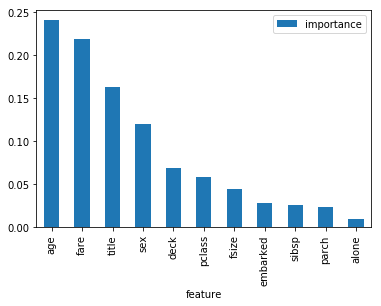

In [118]:
importances.plot.bar()

## Comparação final entre os algoritmos

In [119]:
results = pd.DataFrame({'Algorithm': names, 'Score': scores, 'Std Dev': stddevs, 'Time (ms)': times})
results.sort_values(by='Score', ascending=False)

,Algorithm,Score,Std Dev,Time (ms)
9,VC,80.9679,2.0193,19929
8,XGB,80.7380,2.4173,3663
7,GB,80.1672,2.9873,6839
0,LR,79.9412,5.1163,6181
1,DT,79.4775,4.0294,325
6,RF,78.5567,2.8934,10964
2,NB,76.0436,6.2446,343
5,MLP,75.4585,4.9320,14153
3,KNN,70.4206,3.4389,467
4,SVM,69.7322,4.3057,4712


## Gerar arquivos com resultados

In [120]:
# criar diretório para os arquivos de envio
!test -d submissions || mkdir submissions

In [121]:
prefixo_arquivo = 'submissions/titanic-submission'
sufixo_arquivo = '06jul'

for name, model in models:
    print(model, '\n')
    
    # treinar o modelo
    model.fit(X_train, y_train)
    
    # executar previsão usando o modelo
    y_pred = model.predict(X_test)
    vfunc = np.vectorize(lambda x: 'yes' if x > 0 else 'no')

    # gerar dados de envio (submissão)
    submission = pd.DataFrame({
      'person': X_test.index,
      'survived': vfunc(y_pred)
    })
    submission.set_index('person', inplace=True)

    # gerar arquivo CSV para o envio
    filename = '%s-p-%s-%s.csv' % (prefixo_arquivo, sufixo_arquivo, name.lower())
    submission.to_csv(filename)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best') 

GaussianNB(priors=None, var_smoothing=1e-08) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform') 

SVC(C=10, cache_size=200, class_weig

In [122]:
!head submissions/*.csv

==> submissions/titanic-submission-p-03jul-abdt.csv <==
person,survived
76,yes
87,yes
376,no
645,no
976,no
584,yes
769,no
628,no
1036,no

==> submissions/titanic-submission-p-03jul-dt.csv <==
person,survived
76,yes
87,no
376,no
645,no
976,no
584,yes
769,no
628,no
1036,no

==> submissions/titanic-submission-p-03jul-gb.csv <==
person,survived
76,yes
87,no
376,no
645,no
976,no
584,yes
769,no
628,no
1036,yes

==> submissions/titanic-submission-p-03jul-knn.csv <==
person,survived
76,yes
87,yes
376,no
645,no
976,no
584,yes
769,no
628,no
1036,no

==> submissions/titanic-submission-p-03jul-lda.csv <==
person,survived
76,yes
87,no
376,no
645,no
976,no
584,yes
769,no
628,yes
1036,yes

==> submissions/titanic-submission-p-03jul-lr.csv <==
person,survived
76,yes
87,no
376,no
645,no
976,no
584,yes
769,no
628,no
1036,yes

==> submissions/titanic-submission-p-03jul-lsvm.csv <==
person,survived
76,yes
87,no
376,no
645,no
976,no
584,yes
769,no
628,no
1036,yes

==> submissions/titanic-submission-p-03jul